In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings as warn
warn.filterwarnings('ignore')
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import math
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling1D, Attention, Concatenate, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving btc_usd(date&Close).csv to btc_usd(date&Close).csv


In [ ]:
import pandas as pd

btc_cc = pd.read_csv("btc_usd(date&Close).csv")

print(btc_cc.head())


         Date       Close
0  2014-09-17  457.334015
1  2014-09-18  424.440002
2  2014-09-19  394.795990
3  2014-09-20  408.903992
4  2014-09-21  398.821014


In [ ]:
btc_cc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3848 entries, 0 to 3847
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3848 non-null   object 
 1   Close   3848 non-null   float64
dtypes: float64(1), object(1)
memory usage: 60.3+ KB


Converting the strings in the Date column to datetime format

In [ ]:
btc_cc['Date'] = pd.to_datetime(btc_cc['Date'])

# **Sliding window one-step ahead forecasting**

In [ ]:
closing_prices = btc_cc['Close'].values
dates = btc_cc['Date'].values

# In this code 10 previous days will be used to predict the next day's price
window_size = 10

# Preparing the input (X), target (y), and target date using a sliding window
X, y, y_dates = [], [], []
for current_day_index in range(window_size, len(closing_prices)):
    ten_days_window = closing_prices[current_day_index - window_size:current_day_index]  # previous 10 days
    target_day = closing_prices[current_day_index]  # next day's price
    target_date = dates[current_day_index]  # next day's date

    X.append(ten_days_window)
    y.append(target_day)
    y_dates.append(target_date)

X = np.array(X)
y = np.array(y)
y_dates = np.array(y_dates)

print(f"Input shape (X): {X.shape}")
print(f"Target shape (y): {y.shape}")
print("Example input:", X[0])
print("Expected output:", y[0])

# Reshaping X
X = X.reshape((X.shape[0], X.shape[1], 1))
print(f"Reshaped input for Transformer: {X.shape}")

Input shape (X): (3838, 10)
Target shape (y): (3838,)
Example input: [457.33401489 424.44000244 394.79598999 408.9039917  398.8210144
 402.15200806 435.79098511 423.20498657 411.57400513 404.42498779]
Expected output: 399.5199890136719
Reshaped input for Transformer: (3838, 10, 1)


**DAta Splitting into Training and Testing**

In [ ]:
split_date = np.datetime64('2025-01-01')
before_split_date = y_dates < split_date
from_2025_onward = y_dates >= split_date

# Splitting the dataset in to training and testing
X_train, X_test = X[before_split_date], X[from_2025_onward]
y_train, y_test = y[before_split_date], y[from_2025_onward]

print(f"\nTraining set of BTC closing prices:  X = {X_train.shape},  y = {y_train.shape}")
print(f"Testing set of BTC closing prices:   X = {X_test.shape},   y = {y_test.shape}")


Training set of BTC closing prices:  X = (3749, 10, 1),  y = (3749,)
Testing set of BTC closing prices:   X = (89, 10, 1),   y = (89,)


**Scaling the Data using Robust Scaler**

In [ ]:
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])

x_scaler = RobustScaler()
X_train_scaled = x_scaler.fit_transform(X_train_reshaped)
X_test_scaled = x_scaler.transform(X_test_reshaped)

X_train_scaled = X_train_scaled.reshape(X_train.shape)
X_test_scaled = X_test_scaled.reshape(X_test.shape)

y_scaler = RobustScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).flatten()

In [ ]:
X_train_scaled

array([[[-0.30396439],
        [-0.30508881],
        [-0.30610215],
        ...,
        [-0.30513103],
        [-0.30552862],
        [-0.30577299]],

       [[-0.30508881],
        [-0.30610215],
        [-0.30561989],
        ...,
        [-0.30552862],
        [-0.30577299],
        [-0.30594066]],

       [[-0.30610215],
        [-0.30561989],
        [-0.30596456],
        ...,
        [-0.30577299],
        [-0.30594066],
        [-0.30670429]],

       ...,

       [[ 3.01297192],
        [ 3.02202971],
        [ 3.0038714 ],
        ...,
        [ 2.95501615],
        [ 2.89927482],
        [ 2.93342641]],

       [[ 3.02202971],
        [ 3.0038714 ],
        [ 2.93140986],
        ...,
        [ 2.89927482],
        [ 2.93342641],
        [ 2.87758093]],

       [[ 3.0038714 ],
        [ 2.93140986],
        [ 2.91709744],
        ...,
        [ 2.93342641],
        [ 2.87758093],
        [ 2.84725975]]])

In [ ]:
y_test_scaled

array([2.89603143, 2.98004471, 3.02160852, 3.02599447, 3.02867563,
       3.15682214, 2.98126477, 2.91727266, 2.83011398, 2.90562407,
       2.90103167, 2.8983702 , 2.89932661, 2.96802978, 3.10323621,
       3.07777851, 3.23800342, 3.23616561, 3.12316134, 3.15473053,
       3.29535675, 3.21045543, 3.22091322, 3.25017558, 3.24660558,
       3.17740439, 3.15714911, 3.13143175, 3.21216288, 3.24730899,
       3.16795542, 3.10839235, 3.00735885, 3.13391577, 3.01358527,
       2.97080166, 2.97004743, 2.96786084, 2.96627285, 2.96687357,
       2.99879713, 2.94124293, 3.01406334, 2.97108845, 3.001229  ,
       3.00365982, 2.95580414, 2.94212672, 2.93416385, 2.97148831,
       3.02932184, 2.95411904, 2.96951828, 2.95917169, 2.79381778,
       2.70248705, 2.55302242, 2.56518634, 2.55390728, 2.61039837,
       2.8901945 , 2.61154793, 2.65093128, 2.76675877, 2.74422113,
       2.63460196, 2.61457601, 2.42545961, 2.35500217, 2.50245978,
       2.5317506 , 2.44131696, 2.54015297, 2.55288914, 2.49283

# **Transformer Regression Model**

In [ ]:
#Building a Transformer-style model for Bitcoin price prediction using block-wise attention

def BTC_Transformer(input_shape, num_blocks):
    input_layer = Input(shape=input_shape)
    block_attention_outputs = []

    time_steps = input_shape[0]
    block_size = time_steps // num_blocks

    # Go through the input in blocks
    for block_index in range(num_blocks):
        start_index = block_index * block_size
        end_index = (block_index + 1) * block_size
        time_block = Lambda(lambda x: x[:, start_index:end_index, :])(input_layer)
        attention_output = Attention()([time_block, time_block])
        block_attention_outputs.append(attention_output)

    merged_blocks = Concatenate(axis=1)(block_attention_outputs)
    compressed_time_vector = GlobalAveragePooling1D()(merged_blocks)
    output_layer = Dense(1)(compressed_time_vector) #(eg: next BTC price)

    # Build and return the transformer model
    transformer_model = Model(inputs=input_layer, outputs=output_layer)
    return transformer_model

In [ ]:
input_shape = X_train.shape[1:]
epochs = 50
batch_size = 32

**Transformer with one attention block**

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0530 - mae: 0.1610 - val_loss: 0.2330 - val_mae: 0.4022
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0323 - mae: 0.1343 - val_loss: 0.1436 - val_mae: 0.3122
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0204 - mae: 0.1080 - val_loss: 0.0889 - val_mae: 0.2431
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0141 - mae: 0.0858 - val_loss: 0.0539 - val_mae: 0.1862
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0083 - mae: 0.0628 - val_loss: 0.0320 - val_mae: 0.1381
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0056 - mae: 0.0502 - val_loss: 0.0201 - val_mae: 0.1048
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0041 - mae: 0.0402 - val_loss: 0.0138 - val_mae: 0.0837
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034 - mae: 0.0348 - val_loss: 0.0109 - val_mae: 0.0732
Epoch 9/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033 - mae:

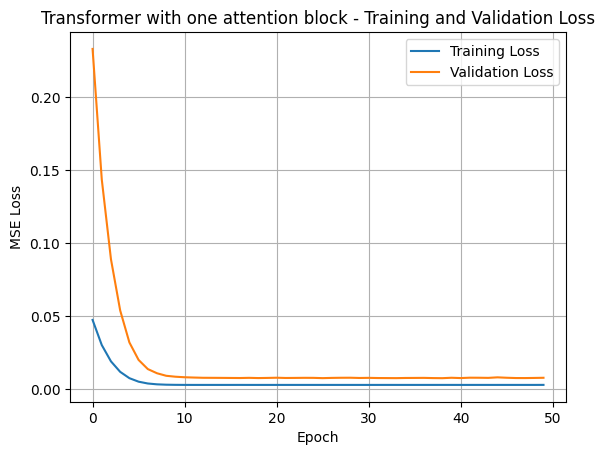

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

 Metrics: Transformer with one attention block:
MAE  - 2857.2489
MSE  - 14125959.5807
RMSE - 3758.4518
R²   - 0.7378
MAPE - 3.12%



In [ ]:
one_block_transformer = BTC_Transformer(input_shape, num_blocks=1)
one_block_transformer.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
history_one_block_transformer = one_block_transformer.fit(X_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

# Plotting training and validation loss over epochs
plt.plot(history_one_block_transformer.history['loss'], label='Training Loss')
plt.plot(history_one_block_transformer.history['val_loss'], label='Validation Loss')
plt.title('Transformer with one attention block - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

#Predicting the closing price of BTC
y_pred = one_block_transformer.predict(X_test_scaled).flatten()
y_test_inverse = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
y_pred_inverse = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

print(f"\n Metrics: Transformer with one attention block:")
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
print(f"MAE  - {mae:.4f}")
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
print(f"MSE  - {mse:.4f}")
rmse = math.sqrt(mse)
print(f"RMSE - {rmse:.4f}")
r2 = r2_score(y_test_inverse, y_pred_inverse)
print(f"R²   - {r2:.4f}")
mape = mean_absolute_percentage_error(y_test_inverse, y_pred_inverse) * 100
print(f"MAPE - {mape:.2f}%\n")


Some test predictions of Transformer with one attenton block

Sample 1
Last 10 days input (closing btc price): [2.93140986 2.91709744 3.05348403 3.07478374 2.95501615 2.89927482
 2.93342641 2.87758093 2.84725975 2.87412761]
Actual BTC closing price      : 94419.7578125
Predicted BTC closing price   : 94987.5390625

Sample 2
Last 10 days input (closing btc price): [2.91709744 3.05348403 3.07478374 2.95501615 2.89927482 2.93342641
 2.87758093 2.84725975 2.87412761 2.90798811]
Actual BTC closing price      : 96886.875
Predicted BTC closing price   : 94929.5625

Sample 3
Last 10 days input (closing btc price): [3.05348403 3.07478374 2.95501615 2.89927482 2.93342641 2.87758093
 2.84725975 2.87412761 2.90798811 2.99232249]
Actual BTC closing price      : 98107.4296875
Predicted BTC closing price   : 95156.484375

Sample 4
Last 10 days input (closing btc price): [3.07478374 2.95501615 2.89927482 2.93342641 2.87758093 2.84725975
 2.87412761 2.90798811 2.99232249 3.03404517]
Actual BTC closing

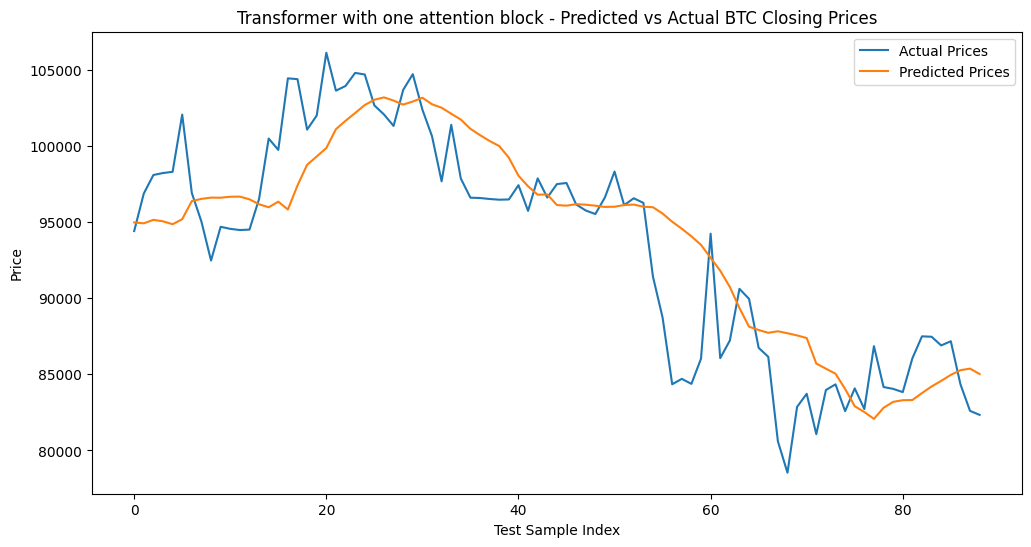

In [ ]:
print("\nSome test predictions of Transformer with one attenton block\n")

for day_index in range(5):
    print(f"Sample {day_index+1}")
    print("Last 10 days input (closing btc price):", X_test_scaled[day_index].flatten())
    print(f"Actual BTC closing price      : {y_test_inverse[day_index]}")
    print(f"Predicted BTC closing price   : {y_pred_inverse[day_index]}\n")

# Plotting actual vs predicted prices on test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Prices')
plt.plot(y_pred_inverse, label='Predicted Prices')
plt.title('Transformer with one attention block - Predicted vs Actual BTC Closing Prices')
plt.xlabel('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()

**Transformer with two attention blocks**

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2738 - mae: 0.3582 - val_loss: 1.3983 - val_mae: 1.0051
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1856 - mae: 0.3136 - val_loss: 1.0806 - val_mae: 0.8745
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1697 - mae: 0.3154 - val_loss: 0.8587 - val_mae: 0.7769
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1233 - mae: 0.2697 - val_loss: 0.6735 - val_mae: 0.6858
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1023 - mae: 0.2503 - val_loss: 0.5292 - val_mae: 0.6075
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0808 - mae: 0.2195 - val_loss: 0.4130 - val_mae: 0.5366
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0654 - mae: 0.1979 - val_loss: 0.3161 - val_mae: 0.4691
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0497 - mae: 0.1719 - val_loss: 0.2381 - val_mae: 0.4066
Epoch 9/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0371 - mae: 

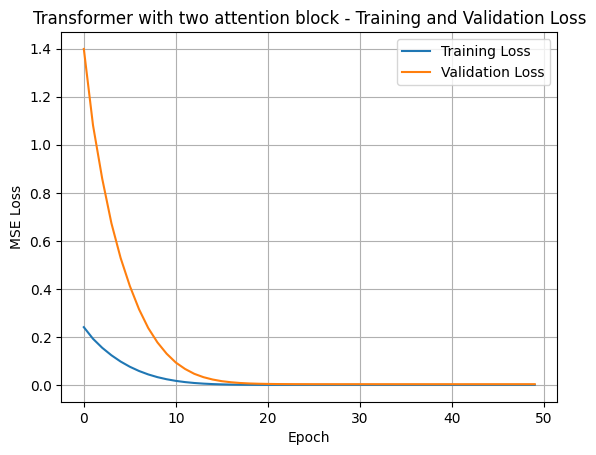

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

 Metrics: Transformer with two attention block:
MAE  - 2400.3519
MSE  - 10882294.6731
RMSE - 3298.8323
R²   - 0.7980
MAPE - 2.62%



In [ ]:
two_block_transformer = BTC_Transformer(input_shape, num_blocks=2)
two_block_transformer.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
history_two_block_transformer = two_block_transformer.fit(X_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

# Plotting training and validation loss over epochs
plt.plot(history_two_block_transformer.history['loss'], label='Training Loss')
plt.plot(history_two_block_transformer.history['val_loss'], label='Validation Loss')
plt.title('Transformer with two attention block - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

#Predicting the closing price of BTC
y_pred = two_block_transformer.predict(X_test_scaled).flatten()
y_test_inverse = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
y_pred_inverse = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

print(f"\n Metrics: Transformer with two attention block:")
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
print(f"MAE  - {mae:.4f}")
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
print(f"MSE  - {mse:.4f}")
rmse = math.sqrt(mse)
print(f"RMSE - {rmse:.4f}")
r2 = r2_score(y_test_inverse, y_pred_inverse)
print(f"R²   - {r2:.4f}")
mape = mean_absolute_percentage_error(y_test_inverse, y_pred_inverse) * 100
print(f"MAPE - {mape:.2f}%\n")


Some test predictions of Transformer with two attenton block

Sample 1
Last 10 days input (closing btc price): [2.93140986 2.91709744 3.05348403 3.07478374 2.95501615 2.89927482
 2.93342641 2.87758093 2.84725975 2.87412761]
Actual BTC closing price      : 94419.7578125
Predicted BTC closing price   : 93444.3828125

Sample 2
Last 10 days input (closing btc price): [2.91709744 3.05348403 3.07478374 2.95501615 2.89927482 2.93342641
 2.87758093 2.84725975 2.87412761 2.90798811]
Actual BTC closing price      : 96886.875
Predicted BTC closing price   : 93499.578125

Sample 3
Last 10 days input (closing btc price): [3.05348403 3.07478374 2.95501615 2.89927482 2.93342641 2.87758093
 2.84725975 2.87412761 2.90798811 2.99232249]
Actual BTC closing price      : 98107.4296875
Predicted BTC closing price   : 93994.0078125

Sample 4
Last 10 days input (closing btc price): [3.07478374 2.95501615 2.89927482 2.93342641 2.87758093 2.84725975
 2.87412761 2.90798811 2.99232249 3.03404517]
Actual BTC clos

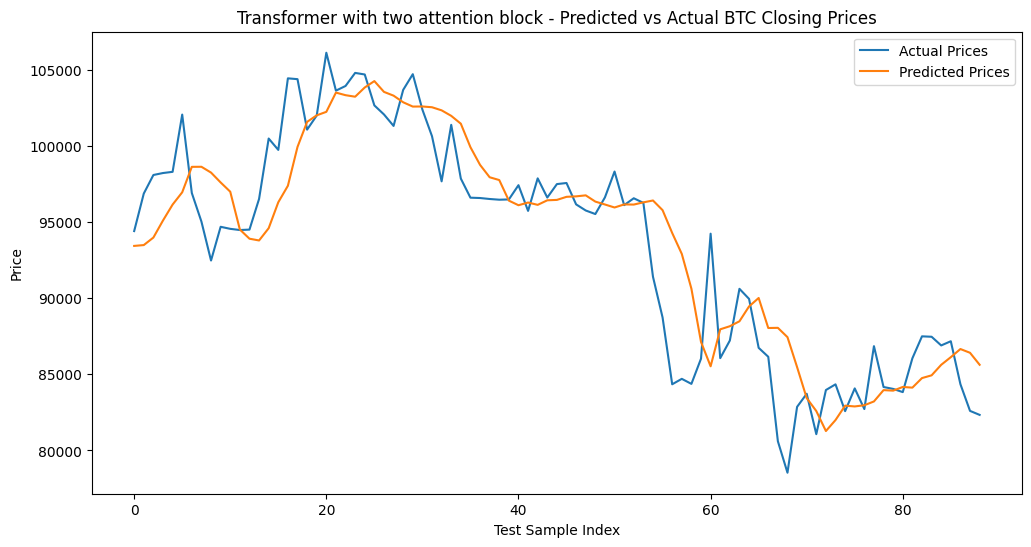

In [ ]:
print("\nSome test predictions of Transformer with two attenton block\n")

for day_index in range(5):
    print(f"Sample {day_index+1}")
    print("Last 10 days input (closing btc price):", X_test_scaled[day_index].flatten())
    print(f"Actual BTC closing price      : {y_test_inverse[day_index]}")
    print(f"Predicted BTC closing price   : {y_pred_inverse[day_index]}\n")

# Plotting actual vs predicted prices on test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Prices')
plt.plot(y_pred_inverse, label='Predicted Prices')
plt.title('Transformer with two attention block - Predicted vs Actual BTC Closing Prices')
plt.xlabel('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()

**Transformer with three attention blocks**

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.3759 - mae: 0.4197 - val_loss: 2.1638 - val_mae: 1.2513
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3156 - mae: 0.4067 - val_loss: 1.7638 - val_mae: 1.1204
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2794 - mae: 0.3942 - val_loss: 1.4480 - val_mae: 1.0102
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2264 - mae: 0.3643 - val_loss: 1.1904 - val_mae: 0.9131
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1931 - mae: 0.3368 - val_loss: 0.9858 - val_mae: 0.8303
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1627 - mae: 0.3087 - val_loss: 0.8122 - val_mae: 0.7538
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1244 - mae: 0.2748 - val_loss: 0.6610 - val_mae: 0.6795
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1050 - mae: 0.2482 - val_loss: 0.5324 - val_mae: 0.6094
Epoch 9/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0886 - mae: 

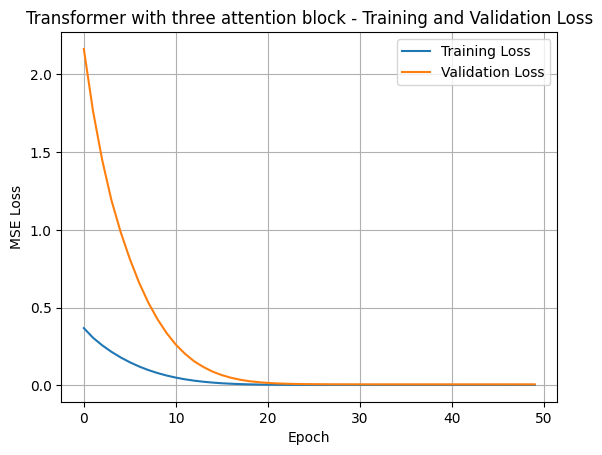

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

 Metrics: Transformer with three attention block:
MAE  - 2490.4465
MSE  - 12022627.5793
RMSE - 3467.3661
R²   - 0.7769
MAPE - 2.71%



In [ ]:
three_block_transformer = BTC_Transformer(input_shape, num_blocks=3)
three_block_transformer.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
history_three_block_transformer = three_block_transformer.fit(X_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

# Plotting training and validation loss over epochs
plt.plot(history_three_block_transformer.history['loss'], label='Training Loss')
plt.plot(history_three_block_transformer.history['val_loss'], label='Validation Loss')
plt.title('Transformer with three attention block - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

#Predicting the closing price of BTC
y_pred = three_block_transformer.predict(X_test_scaled).flatten()
y_test_inverse = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
y_pred_inverse = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

print(f"\n Metrics: Transformer with three attention block:")
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
print(f"MAE  - {mae:.4f}")
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
print(f"MSE  - {mse:.4f}")
rmse = math.sqrt(mse)
print(f"RMSE - {rmse:.4f}")
r2 = r2_score(y_test_inverse, y_pred_inverse)
print(f"R²   - {r2:.4f}")
mape = mean_absolute_percentage_error(y_test_inverse, y_pred_inverse) * 100
print(f"MAPE - {mape:.2f}%\n")


Some test predictions of Transformer with three attenton block

Sample 1
Last 10 days input (closing btc price): [2.93140986 2.91709744 3.05348403 3.07478374 2.95501615 2.89927482
 2.93342641 2.87758093 2.84725975 2.87412761]
Actual BTC closing price      : 94419.7578125
Predicted BTC closing price   : 93513.546875

Sample 2
Last 10 days input (closing btc price): [2.91709744 3.05348403 3.07478374 2.95501615 2.89927482 2.93342641
 2.87758093 2.84725975 2.87412761 2.90798811]
Actual BTC closing price      : 96886.875
Predicted BTC closing price   : 92844.625

Sample 3
Last 10 days input (closing btc price): [3.05348403 3.07478374 2.95501615 2.89927482 2.93342641 2.87758093
 2.84725975 2.87412761 2.90798811 2.99232249]
Actual BTC closing price      : 98107.4296875
Predicted BTC closing price   : 93176.484375

Sample 4
Last 10 days input (closing btc price): [3.07478374 2.95501615 2.89927482 2.93342641 2.87758093 2.84725975
 2.87412761 2.90798811 2.99232249 3.03404517]
Actual BTC closing

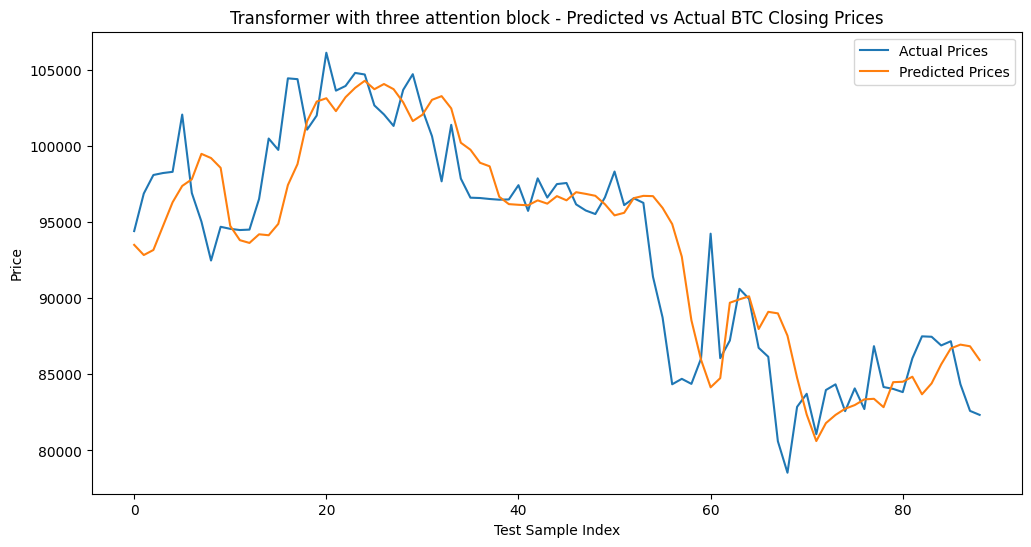

In [ ]:
print("\nSome test predictions of Transformer with three attenton block\n")

for day_index in range(5):
    print(f"Sample {day_index+1}")
    print("Last 10 days input (closing btc price):", X_test_scaled[day_index].flatten())
    print(f"Actual BTC closing price      : {y_test_inverse[day_index]}")
    print(f"Predicted BTC closing price   : {y_pred_inverse[day_index]}\n")

# Plotting actual vs predicted prices on test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Prices')
plt.plot(y_pred_inverse, label='Predicted Prices')
plt.title('Transformer with three attention block - Predicted vs Actual BTC Closing Prices')
plt.xlabel('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()

**Transformer with four attention blocks**

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2181 - mae: 1.0070 - val_loss: 13.1660 - val_mae: 3.1101
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1064 - mae: 0.9994 - val_loss: 11.9763 - val_mae: 2.9518
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8052 - mae: 0.9514 - val_loss: 10.8869 - val_mae: 2.8015
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5474 - mae: 0.9004 - val_loss: 9.9257 - val_mae: 2.6644
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5667 - mae: 0.9269 - val_loss: 9.0793 - val_mae: 2.5404
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4063 - mae: 0.8889 - val_loss: 8.3508 - val_mae: 2.4312
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3288 - mae: 0.8698 - val_loss: 7.6758 - val_mae: 2.3267
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2113 - mae: 0.8358 - val_loss: 7.0539 - val_mae: 2.2273
Epoch 9/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1508 - ma

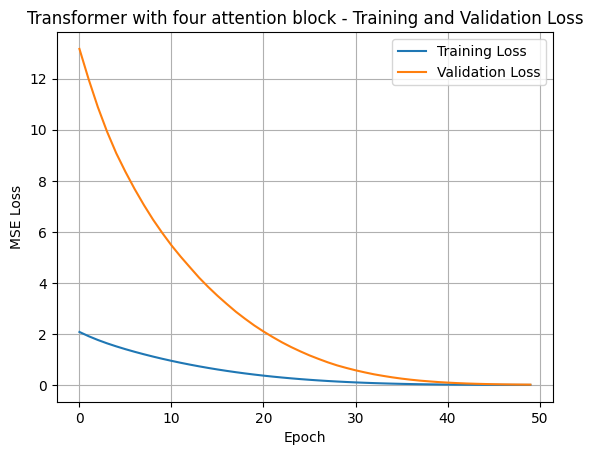

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

 Metrics: Transformer with four attention block:
MAE  - 4984.9974
MSE  - 32279660.6931
RMSE - 5681.5192
R²   - 0.4009
MAPE - 5.29%



In [ ]:
four_block_transformer = BTC_Transformer(input_shape, num_blocks=4)
four_block_transformer.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
history_four_block_transformer = four_block_transformer.fit(X_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

# Plotting training and validation loss over epochs
plt.plot(history_four_block_transformer.history['loss'], label='Training Loss')
plt.plot(history_four_block_transformer.history['val_loss'], label='Validation Loss')
plt.title('Transformer with four attention block - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

#Predicting the closing price of BTC
y_pred = four_block_transformer.predict(X_test_scaled).flatten()
y_test_inverse = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
y_pred_inverse = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

print(f"\n Metrics: Transformer with four attention block:")
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
print(f"MAE  - {mae:.4f}")
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
print(f"MSE  - {mse:.4f}")
rmse = math.sqrt(mse)
print(f"RMSE - {rmse:.4f}")
r2 = r2_score(y_test_inverse, y_pred_inverse)
print(f"R²   - {r2:.4f}")
mape = mean_absolute_percentage_error(y_test_inverse, y_pred_inverse) * 100
print(f"MAPE - {mape:.2f}%\n")


Some test predictions of Transformer with four attenton block

Sample 1
Last 10 days input (closing btc price): [2.93140986 2.91709744 3.05348403 3.07478374 2.95501615 2.89927482
 2.93342641 2.87758093 2.84725975 2.87412761]
Actual BTC closing price      : 94419.7578125
Predicted BTC closing price   : 89611.234375

Sample 2
Last 10 days input (closing btc price): [2.91709744 3.05348403 3.07478374 2.95501615 2.89927482 2.93342641
 2.87758093 2.84725975 2.87412761 2.90798811]
Actual BTC closing price      : 96886.875
Predicted BTC closing price   : 88381.375

Sample 3
Last 10 days input (closing btc price): [3.05348403 3.07478374 2.95501615 2.89927482 2.93342641 2.87758093
 2.84725975 2.87412761 2.90798811 2.99232249]
Actual BTC closing price      : 98107.4296875
Predicted BTC closing price   : 88329.9609375

Sample 4
Last 10 days input (closing btc price): [3.07478374 2.95501615 2.89927482 2.93342641 2.87758093 2.84725975
 2.87412761 2.90798811 2.99232249 3.03404517]
Actual BTC closing

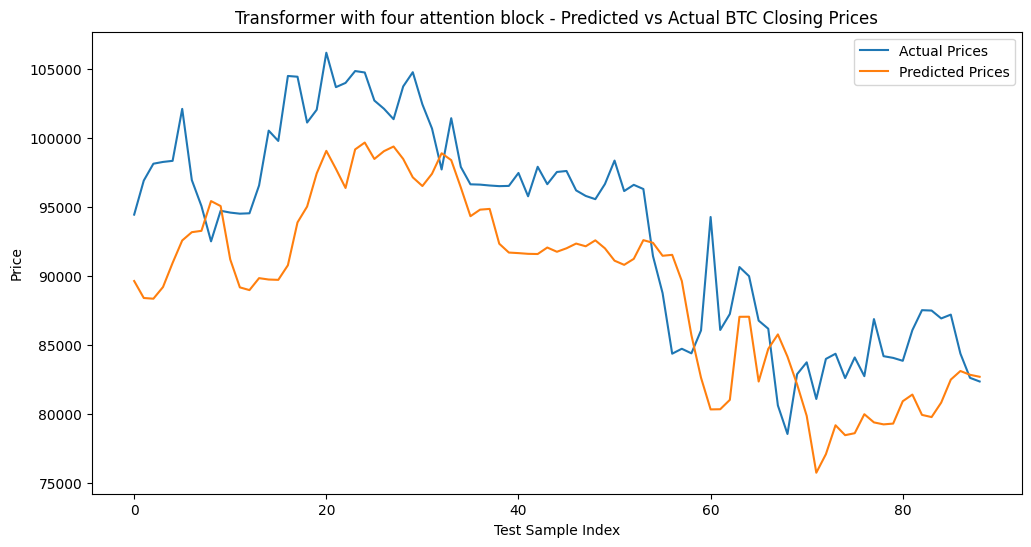

In [ ]:
print("\nSome test predictions of Transformer with four attenton block\n")

for day_index in range(5):
    print(f"Sample {day_index+1}")
    print("Last 10 days input (closing btc price):", X_test_scaled[day_index].flatten())
    print(f"Actual BTC closing price      : {y_test_inverse[day_index]}")
    print(f"Predicted BTC closing price   : {y_pred_inverse[day_index]}\n")

# Plotting actual vs predicted prices on test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Prices')
plt.plot(y_pred_inverse, label='Predicted Prices')
plt.title('Transformer with four attention block - Predicted vs Actual BTC Closing Prices')
plt.xlabel('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()

**Transformer with five attention blocks**

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0084 - mae: 0.0597 - val_loss: 0.0159 - val_mae: 0.0919
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0041 - mae: 0.0389 - val_loss: 0.0077 - val_mae: 0.0600
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026 - mae: 0.0272 - val_loss: 0.0068 - val_mae: 0.0551
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0024 - mae: 0.0245 - val_loss: 0.0070 - val_mae: 0.0558
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023 - mae: 0.0239 - val_loss: 0.0071 - val_mae: 0.0559
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 - mae: 0.0225 - val_loss: 0.0070 - val_mae: 0.0557
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022 - mae: 0.0235 - val_loss: 0.0070 - val_mae: 0.0557
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024 - mae: 0.0245 - val_loss: 0.0070 - val_mae: 0.0557
Epoch 9/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024 - mae: 

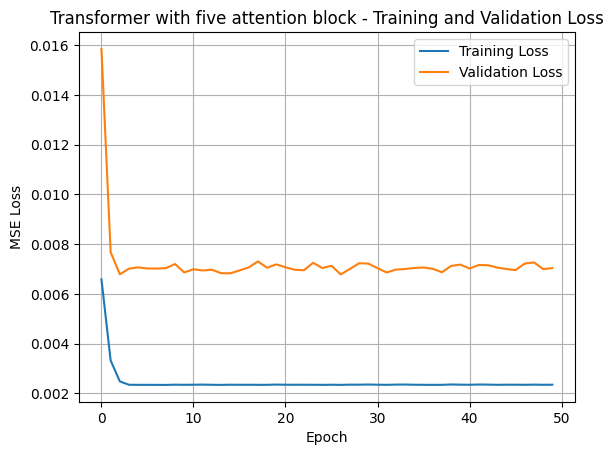

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

 Metrics: Transformer with five attention block:
MAE  - 2770.0797
MSE  - 14565156.5569
RMSE - 3816.4324
R²   - 0.7297
MAPE - 3.02%



In [ ]:
five_block_transformer = BTC_Transformer(input_shape, num_blocks=4)
five_block_transformer.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
history_five_block_transformer = five_block_transformer.fit(X_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

# Plotting training and validation loss over epochs
plt.plot(history_five_block_transformer.history['loss'], label='Training Loss')
plt.plot(history_five_block_transformer.history['val_loss'], label='Validation Loss')
plt.title('Transformer with five attention block - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

#Predicting the closing price of BTC
y_pred = five_block_transformer.predict(X_test_scaled).flatten()
y_test_inverse = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
y_pred_inverse = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

print(f"\n Metrics: Transformer with five attention block:")
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
print(f"MAE  - {mae:.4f}")
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
print(f"MSE  - {mse:.4f}")
rmse = math.sqrt(mse)
print(f"RMSE - {rmse:.4f}")
r2 = r2_score(y_test_inverse, y_pred_inverse)
print(f"R²   - {r2:.4f}")
mape = mean_absolute_percentage_error(y_test_inverse, y_pred_inverse) * 100
print(f"MAPE - {mape:.2f}%\n")


Some test predictions of Transformer with five attenton block

Sample 1
Last 10 days input (closing btc price): [2.93140986 2.91709744 3.05348403 3.07478374 2.95501615 2.89927482
 2.93342641 2.87758093 2.84725975 2.87412761]
Actual BTC closing price      : 94419.7578125
Predicted BTC closing price   : 94008.2578125

Sample 2
Last 10 days input (closing btc price): [2.91709744 3.05348403 3.07478374 2.95501615 2.89927482 2.93342641
 2.87758093 2.84725975 2.87412761 2.90798811]
Actual BTC closing price      : 96886.875
Predicted BTC closing price   : 92707.3671875

Sample 3
Last 10 days input (closing btc price): [3.05348403 3.07478374 2.95501615 2.89927482 2.93342641 2.87758093
 2.84725975 2.87412761 2.90798811 2.99232249]
Actual BTC closing price      : 98107.4296875
Predicted BTC closing price   : 92652.984375

Sample 4
Last 10 days input (closing btc price): [3.07478374 2.95501615 2.89927482 2.93342641 2.87758093 2.84725975
 2.87412761 2.90798811 2.99232249 3.03404517]
Actual BTC clo

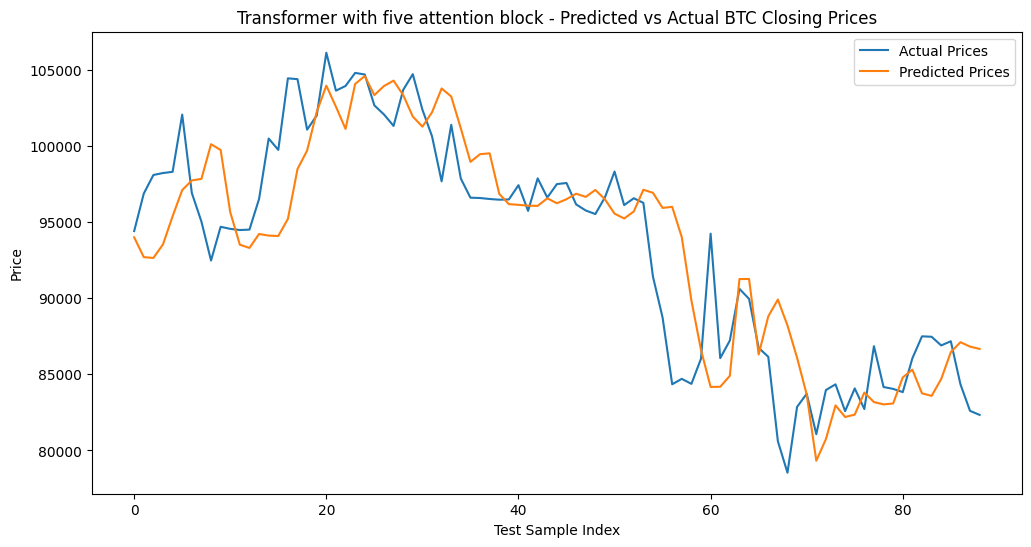

In [ ]:
print("\nSome test predictions of Transformer with five attenton block\n")

for day_index in range(5):
    print(f"Sample {day_index+1}")
    print("Last 10 days input (closing btc price):", X_test_scaled[day_index].flatten())
    print(f"Actual BTC closing price      : {y_test_inverse[day_index]}")
    print(f"Predicted BTC closing price   : {y_pred_inverse[day_index]}\n")

# Plotting actual vs predicted prices on test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Prices')
plt.plot(y_pred_inverse, label='Predicted Prices')
plt.title('Transformer with five attention block - Predicted vs Actual BTC Closing Prices')
plt.xlabel('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()